In [22]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from scipy.stats import ortho_group
from sklearn.svm import SVC 
import math 
import random
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.linear_model import orthogonal_mp
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
cd Desktop/LANL/AFRL-DISC Data/Blackbox brief for LANL

C:\Users\khenk\Desktop\LANL\AFRL-DISC Data\Blackbox brief for LANL


In [3]:
#binary spca components
#Load sPCA Dictionary from found sPCA components
mat = sio.loadmat('sPCA_Phi.mat')
sPCA_Phi = mat['sPCA_Phi']

sPCA= pd.read_csv('sPCA_32.csv', sep=',', encoding = 'utf8')
data = sPCA.values
data= np.dot(data,sPCA_Phi)

# data = np.load('Repatched_Dwave_Data_7x7.npy')
# data = data.reshape(len(data),28*28)
# mat = sio.loadmat('data_binned.mat')
# data_binned = np.asarray(mat['data_binned'])
# data_binned = np.dot(data_binned,sPCA_Phi)
#data_binned = np.reshape(len(data_binned),)

In [4]:
mat = sio.loadmat('fMnist_ytrainlabels.mat')
Y_train = np.squeeze(np.asarray(mat['y_train'].T))
mat = sio.loadmat('fMnist_ytestlabels.mat')
Y_test = np.squeeze(np.asarray(mat['y_test'].T))

In [5]:
X_train = data[0:len(Y_train)]
X_test = data[len(Y_train):len(data)]

In [6]:
data = data.reshape(len(data),28*28)

In [7]:
data1 = data*(-1)
data1 = data1.reshape(len(data1),28,28)
data = data.reshape(len(data),28,28)
X_train = data[0:len(Y_train)]
X_test = data[len(Y_train):len(data)]
X_train1 = data1[0:len(Y_train)]
X_test1 = data1[len(Y_train):len(data)]

In [8]:
X_train_final = np.concatenate((X_train,X_train1))
X_test_final = np.concatenate((X_test,X_test1))

In [9]:
Y_train1 = Y_train
Y_test1 = Y_test

In [10]:
Y_train = np.concatenate((Y_train,Y_train1))
Y_test = np.concatenate((Y_test,Y_test1))

In [11]:

X_train = X_train_final
X_test = X_test_final
print(X_test.shape, X_train.shape)

(20000, 28, 28) (120000, 28, 28)


In [5]:
np.save('fMNIST_Training_Labels',Y_train)
np.save('fMNIST_Test_Labels',Y_test)

In [23]:
X_train = X_train.reshape(len(X_train),28*28)
X_test = X_test.reshape(len(X_test),28*28)

In [24]:
#Get Random Forest Reference Solution
clf = RandomForestClassifier(n_estimators=100, max_depth = 10, random_state = 1)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.7724

In [ ]:
X_train = X_train_final
X_test = X_test_final
print(X_test.shape, X_train.shape)

[0, 1, 3, 5, 10000, 10001, 10003, 10005]


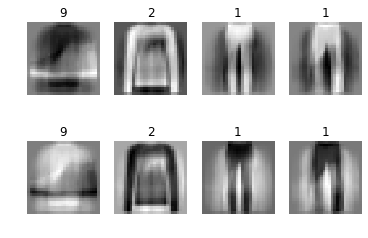

In [12]:
#lets visualize few images 
sample = np.random.randint(0,high= 59999, size=8)
sample = [0,1,3,5,10000,10001,10003, 10005]
print(sample)
sample_img = X_test[sample, :]
sample_label = Y_test[sample]
for i , img in enumerate(sample_img):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    plt.title(sample_label[i])
    img = img.reshape(28,28)
    plt.imshow(img, cmap = 'gray')
plt.show()

In [13]:
#Defining constants
epochs = 30
batch_size = 100
data_augmentation = False
img_size = 28

num_classes = 10
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

In [14]:
x_train = X_train.reshape(X_train.shape[0],img_size,img_size,1)
x_test = X_test.reshape(X_test.shape[0],img_size,img_size,1)
input_size = (img_size, img_size,1)
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('Y_train shape:', Y_train.shape)

#Converting labels to one-hot vectors
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test,num_classes)

x_train shape: (120000, 28, 28, 1)
120000 train samples
20000 test samples
Y_train shape: (120000,)


In [15]:
#Creating model based on ResNet published archietecture
inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 14, 14, 64)   0           batch_normalization_1[0][0]      
_____________________________________

In [16]:
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_resnet_model_sPCA_Polar.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)

C:\Users\khenk\Desktop\LANL\AFRL-DISC Data\Blackbox brief for LANL\saved_model\fmnist_resnet_model_sPCA_Polar.h5


In [17]:
# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

In [18]:
if not data_augmentation:
    print('Not using data augmentation.')
    
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=30,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Train on 120000 samples, validate on 20000 samples
Epoch 1/30
120000/120000 [==============================] - 6539s 54ms/step - loss: 1.1327 - acc: 0.8266 - val_loss: 14.9119 - val_acc: 0.1000

Epoch 00001: val_loss improved from inf to 14.91191, saving model to C:\Users\khenk\Desktop\LANL\AFRL-DISC Data\Blackbox brief for LANL\saved_model\fmnist_resnet_model_sPCA_Polar.h5
Epoch 2/30
120000/120000 [==============================] - 6823s 57ms/step - loss: 0.6708 - acc: 0.8672 - val_loss: 10.8773 - val_acc: 0.1121

Epoch 00002: val_loss improved from 14.91191 to 10.87732, saving model to C:\Users\khenk\Desktop\LANL\AFRL-DISC Data\Blackbox brief for LANL\saved_model\fmnist_resnet_model_sPCA_Polar.h5
Epoch 3/30
120000/120000 [==============================] - 6851s 57ms/step - loss: 0.5470 - acc: 0.8784 - val_loss: 2.2770 - val_acc: 0.3235

Epoch 00003: val_loss improved from 10.87732 to 2.27699, saving model to

In [19]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

20000/20000 [==============================] - 129s 6ms/step
Test loss: 0.993353442955017
Test accuracy: 0.88325


In [ ]:


scores